# 1. Import Necessary Libraries

In [31]:
# Import necessary libraries
import cv2
import numpy as np
import os
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import TensorBoard

# 2. Define Helper Functions
# 2.1 MediaPipe Detection and Drawing Functions

In [3]:
mp_holistic = mp.solutions.holistic  # Holistic model
mp_drawing = mp.solutions.drawing_utils  # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Color conversion
    image.flags.writeable = False
    results = model.process(image)  # Make prediction
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Color conversion
    return image, results

def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(
        image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
        mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
        mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    )
    # Draw pose connections
    mp_drawing.draw_landmarks(
        image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
    )
    # Draw left hand connections
    mp_drawing.draw_landmarks(
        image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
    )
    # Draw right hand connections
    mp_drawing.draw_landmarks(
        image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
    )

def extract_key_points(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]
                    ).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]
                    ).flatten() if results.face_landmarks else np.zeros(468*3)
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]
                         ).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]
                          ).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, left_hand, right_hand])


# 2.2 Data Augmentation Functions

In [5]:
# Noise Injection
def add_noise(sequence, noise_level=0.05):
    noise = np.random.normal(0, noise_level, sequence.shape)
    return sequence + noise

# Scaling
def scale_sequence(sequence, scale_factor=0.1):
    scaling = np.random.normal(1.0, scale_factor)
    return sequence * scaling

# Rotation
def rotate_sequence(sequence, angle_range=10):
    angle = np.random.uniform(-angle_range, angle_range)
    theta = np.deg2rad(angle)
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    rotation_matrix = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])

    sequence_aug = sequence.copy()
    num_frames, num_features = sequence.shape

    for t in range(num_frames):
        frame = sequence[t]
        num_keypoints = int(frame.shape[0] / 3)
        for i in range(num_keypoints):
            idx = i * 3
            x, y = frame[idx], frame[idx+1]
            xy = np.array([x, y])
            rotated_xy = rotation_matrix.dot(xy)
            sequence_aug[t, idx], sequence_aug[t, idx+1] = rotated_xy[0], rotated_xy[1]
    return sequence_aug

# Function to randomly augment a sequence
def augment_sequence(sequence):
    augmented_sequence = sequence.copy()
    if np.random.rand() < 0.5:
        augmented_sequence = add_noise(augmented_sequence)
    if np.random.rand() < 0.5:
        augmented_sequence = scale_sequence(augmented_sequence)
    if np.random.rand() < 0.5:
        augmented_sequence = rotate_sequence(augmented_sequence)
    return augmented_sequence


# 2.3 Visualization Functions

In [7]:
# Function to split keypoints into components
def split_keypoints(frame):
    pose_length = 33 * 4
    face_length = 468 * 3
    left_hand_length = 21 * 3
    right_hand_length = 21 * 3

    pose = frame[:pose_length]
    face = frame[pose_length:pose_length + face_length]
    left_hand = frame[pose_length + face_length:pose_length + face_length + left_hand_length]
    right_hand = frame[pose_length + face_length + left_hand_length:]
    return pose, face, left_hand, right_hand

# Function to plot keypoints
def plot_keypoints(frame, title='Keypoints', plot_face=False):
    pose, face, left_hand, right_hand = split_keypoints(frame)
    plt.figure(figsize=(5,5))
    plt.title(title)
    ax = plt.gca()

    # Plot Pose
    x = pose[::4]
    y = pose[1::4]
    ax.scatter(x, y, c='r', label='Pose')

    # Plot Left Hand
    x = left_hand[::3]
    y = left_hand[1::3]
    ax.scatter(x, y, c='g', label='Left Hand')

    # Plot Right Hand
    x = right_hand[::3]
    y = right_hand[1::3]
    ax.scatter(x, y, c='b', label='Right Hand')

    if plot_face:
        x = face[::3]
        y = face[1::3]
        ax.scatter(x, y, c='gray', label='Face')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.invert_yaxis()
    ax.legend()
    plt.show()


# 3. Data Collection

In [9]:
# Path for exported data
DATA_PATH = os.path.join('AUSLAN_Data')

# Actions that we try to detect
actions = np.array(['A', 'B', 'C', 'D'])

# Number of sequences (videos)
no_sequences = 50

# Length of each sequence (frames)
sequence_length = 30


In [ ]:
# Create directories for each action and sequence
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

## Collect data

In [ ]:
# Collect data
cap = cv2.VideoCapture(0)
# Access MediaPipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Loop through actions
    for action in actions:
        # Loop through sequences (videos)
        for sequence in range(no_sequences):
            # Loop through frames in a sequence
            for frame_num in range(sequence_length):
                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)

                # Apply wait logic
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15,12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15,12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)

                # Export keypoints
                keypoints = extract_key_points(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()

# 4. Data Preparation

In [11]:
# Label mapping
label_map = {label:num for num, label in enumerate(actions)}
print(label_map)

sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])





{'A': 0, 'B': 1, 'C': 2, 'D': 3}


In [ ]:
# Convert to numpy arrays
X = np.array(sequences)
y = to_categorical(labels).astype(int)


In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# 5. Data Augmentation
# 5.1 Augment Training Data

# 5.2 Visualize Augmented Data

In [15]:
augmented_sequences = []
augmented_labels = []

for seq, label in zip(X_train, y_train):
    augmented_seq = augment_sequence(seq)
    augmented_sequences.append(augmented_seq)
    augmented_labels.append(label)

# Convert augmented data to numpy arrays
augmented_sequences = np.array(augmented_sequences)
augmented_labels = np.array(augmented_labels)

# Combine original and augmented data
X_train_augmented = np.concatenate((X_train, augmented_sequences), axis=0)
y_train_augmented = np.concatenate((y_train, augmented_labels), axis=0)

# Shuffle the augmented training data
from sklearn.utils import shuffle
X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented)


# 5.2 Visualize Augmented Data

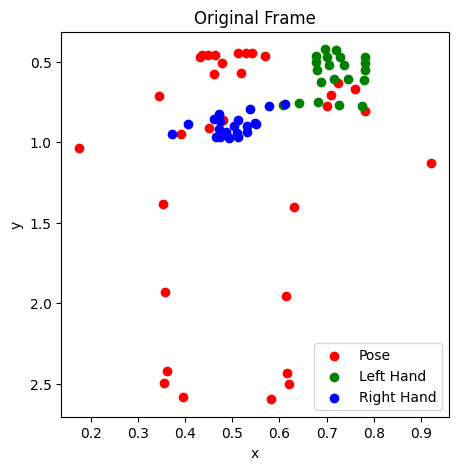

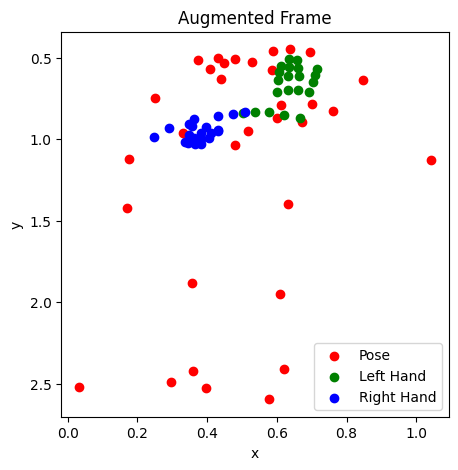

In [18]:
# Select a sample sequence and frame
sample_sequence = X_train[0]
frame_original = sample_sequence[0]

# Apply augmentation for visualization
augmented_sequence = augment_sequence(sample_sequence)
frame_augmented = augmented_sequence[0]

# Plot before and after augmentation
plot_keypoints(frame_original, title='Original Frame')
plot_keypoints(frame_augmented, title='Augmented Frame')


# 6. Model Definition and Training
# 6.1 Define the Model

In [51]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(sequence_length, X.shape[2])))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


c:\Users\khobr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [33]:
# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# 6.2 Train the Model

In [ ]:
# history = model.fit(X_train_augmented, y_train_augmented, epochs=30, batch_size=32, validation_data=(X_test, y_test))


In [34]:
# Model training with the checkpoint callback
history = model.fit(
    X_train_augmented,
    y_train_augmented,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint_callback]
)


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - categorical_accuracy: 0.9138 - loss: 0.2666
Epoch 1: val_categorical_accuracy improved from -inf to 0.90000, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - categorical_accuracy: 0.9148 - loss: 0.2624 - val_categorical_accuracy: 0.9000 - val_loss: 0.2013
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - categorical_accuracy: 0.9214 - loss: 0.2392
Epoch 2: val_categorical_accuracy did not improve from 0.90000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - categorical_accuracy: 0.9163 - loss: 0.2469 - val_categorical_accuracy: 0.7250 - val_loss: 0.8230
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_accuracy: 0.8408 - loss: 0.4177
Epoch 3: val_categorical_accuracy did not improve from 0.90000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - categorical_accuracy: 0.8413 - loss: 0.4186 - val_categorical_accuracy: 0.7000 - val_loss: 0.5458
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - categoric

# 7. Model Evaluation

In [35]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.9021 - loss: 0.2048
Test Loss: 0.219100683927536
Test Accuracy: 0.8999999761581421


In [52]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

# Predict on test set
y_pred = model.predict(X_test)

# Decode predictions to class labels
y_pred_decoded = np.argmax(y_pred, axis=1)
y_test_decoded = np.argmax(y_test, axis=1)

# Calculate multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_test_decoded, y_pred_decoded)

# Display results for each class
for i, action in enumerate(actions):
    print(f"Confusion matrix for class '{action}':")
    print(mcm[i])


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step
Confusion matrix for class 'A':
[[35  0]
 [ 5  0]]
Confusion matrix for class 'B':
[[30  0]
 [10  0]]
Confusion matrix for class 'C':
[[ 0 28]
 [ 1 11]]
Confusion matrix for class 'D':
[[26  1]
 [13  0]]


## Load the best model

### Before run below cell:
- First run our model cell above 
- Then, run compile cell above
- Finally, run below cell

In [ ]:
del model

In [53]:
# Load the best model
from tensorflow.keras.models import load_model

best_model = load_model('best_model.keras')


# 9. Making Predictions

In [54]:
# Evaluate the best model
best_loss, best_accuracy = best_model.evaluate(X_test, y_test)
print(f'Best Model Test Loss: {best_loss}')
print(f'Best Model Test Accuracy: {best_accuracy}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.9833 - loss: 0.0686 
Best Model Test Loss: 0.08720868825912476
Best Model Test Accuracy: 0.9750000238418579


## Confusion Matrix and Accuracy

Example interpretation of a confusion matrix for the class 'A':

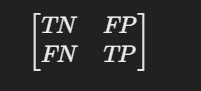
- High FP: The model often predicts 'A' when it's not 'A'. This could indicate that the model is overfitting or confused with similar signs.
- High FN: The model fails to detect 'A' when it should. This could mean the training data for 'A' might be lacking or noisy.
- High TP: The model is doing well in identifying 'A' correctly.
- High TN: The model is good at recognizing when the sign is not 'A'.



In [55]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

# Predict on test set using the best model
y_pred = best_model.predict(X_test)

# Decode predictions to class labels
y_pred_decoded = np.argmax(y_pred, axis=1)
y_test_decoded = np.argmax(y_test, axis=1)

# Calculate multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_test_decoded, y_pred_decoded)

# Display results for each class
for i, action in enumerate(actions):
    print(f"Confusion matrix for class '{action}':")
    print(mcm[i])




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/stepWARNING:tensorflow:5 out of the last 162 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000237B7D7D900> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
Confusion matrix for class 'A':
[[35  0]
 [ 1  4]]
Confusion matrix for class 'B':
[[30  0]
 [ 0 10]]
Confusion matrix for class 'C':
[[28  0]
 [ 0 12]]
Confusion matrix for class 'D':
[[26  1]
 

In [46]:
# Calculate and print overall accuracy
test_accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f'Overall Test Accuracy: {test_accuracy}')

Overall Test Accuracy: 0.975


In [47]:
# Making predictions with the best model
test_seq = X_test[0]
test_seq = np.expand_dims(test_seq, axis=0)
prediction = best_model.predict(test_seq)
predicted_label = actions[np.argmax(prediction)]
print(f'Predicted action: {predicted_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted action: B


## Real Time Detection

In [56]:
# colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]  # RGB values for 'A', 'B', 'C', 'D'

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA) 

    return output_frame

In [60]:
# New Detection vairables
sequence = []
sentence = []
predictions = []
threshold = 0.7

model = best_model


cap = cv2.VideoCapture(0)
# Access midaipipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read the feed
        ret, frame = cap.read()

        # Flip the frame horizontally
        # frame = cv2.flip(frame, 1)

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # draw_landmarks(image, results)
        draw_styled_landmarks(image, results)

        # Prediction
        keypoints = extract_key_points(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        
        # One we got 30 frames, we make a prediction
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))

        # Visualize (keep label same if not different in prediction)
        
            if np.unique(predictions[-10:])[0] == np.argmax(res):
                
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

                if len(sentence) > 5:
                    sentence = sentence[-5:]

                # Show to the screen
                image = prob_viz(res, actions, image, colors)

        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)


 
        # Show to the screen
        cv2.imshow('Frame', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()




<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti